In [31]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex
from qiskit.aqua.operators import TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator
# Loading your IBM Q account(s)
# provider = IBMQ.load_account()

In [3]:
# Define our variables

n = 5 # facility locations
m = 4 # demand nodes
s = 50 # radius of coverage
p = 2 # number of routers 
a = [4, 3, 2, 1] # population at a node

distance
 [[ 0. 86. 39. 70. 88.]
 [86.  0. 48. 57. 11.]
 [39. 48.  0. 49. 50.]
 [70. 57. 49.  0. 49.]
 [88. 11. 50. 49.  0.]]


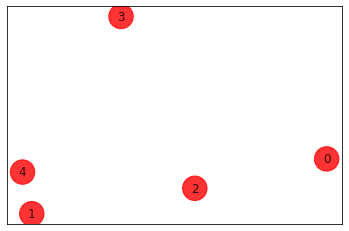

In [4]:
seed = 10598

num_qubits = n ** 2
ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

In [5]:
# get our distance matrix were columns 
ins.w[0:m]

array([[ 0., 86., 39., 70., 88.],
       [86.,  0., 48., 57., 11.],
       [39., 48.,  0., 49., 50.],
       [70., 57., 49.,  0., 49.]])

In [6]:
# get our distance matrix were columns 
ins.w[0:m, m:n]

array([[88.],
       [11.],
       [50.],
       [49.]])

In [7]:
N = []
N.append([0,1,2])
N.append([0,1,2])
N.append([0,1,2,3])
N.append([2,3,4])

In [8]:
# Create an instance of a model and variables

mdl = Model(name='max_vars')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(n)} # facility located at i
y = {i: mdl.binary_var(name='y_{0}'.format(i)) for i in range(m)} # i is covered by a facility
s0 = {i: mdl.binary_var(name='s0_{0}'.format(i)) for i in range(n)} # slack variable
s1 = {i: mdl.binary_var(name='s1_{0}'.format(i)) for i in range(n)} # slack variable

In [9]:
# Objective function
max_vars_func = mdl.sum(a[i]*y[i] for i in range(m))
mdl.maximize(max_vars_func)

In [10]:
# Constraints
for j in range(m):
    mdl.add_constraint(mdl.sum(x[i] for i in N[j]) - s0[j] - s1[j] == y[j] )

In [11]:
# Constraint
mdl.add_constraint(mdl.sum(x[i] for i in range(0,n)) == p)

docplex.mp.LinearConstraint[](x_0+x_1+x_2+x_3+x_4,EQ,2)

In [12]:
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: max_vars

Maximize
 obj: 4 y_0 + 3 y_1 + 2 y_2 + y_3
Subject To
 c1: x_0 + x_1 + x_2 - s0_0 - s1_0 - y_0 = 0
 c2: x_0 + x_1 + x_2 - s0_1 - s1_1 - y_1 = 0
 c3: x_0 + x_1 + x_2 + x_3 - s0_2 - s1_2 - y_2 = 0
 c4: x_2 + x_3 + x_4 - s0_3 - s1_3 - y_3 = 0
 c5: x_0 + x_1 + x_2 + x_3 + x_4 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= y_0 <= 1
 0 <= y_1 <= 1
 0 <= y_2 <= 1
 0 <= y_3 <= 1
 0 <= s0_0 <= 1
 0 <= s0_1 <= 1
 0 <= s0_2 <= 1
 0 <= s0_3 <= 1
 0 <= s0_4 <= 1
 0 <= s1_0 <= 1
 0 <= s1_1 <= 1
 0 <= s1_2 <= 1
 0 <= s1_3 <= 1
 0 <= s1_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 y_0 y_1 y_2 y_3 s0_0 s0_1 s0_2 s0_3 s0_4 s1_0 s1_1 s1_2
 s1_3 s1_4
End



In [13]:
qubitOp, offset = docplex.get_qubitops(mdl)

In [14]:
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

In [15]:
result

{'eigvals': array([-98.5+0.j]),
 'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'energy': -98.5,
 'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'energies': array([-98.5])}

In [16]:
print('objective:', result['energy'] + offset) # offset is the constant part that cannot be optimised 

objective: -10.0


In [17]:
sol = docplex.sample_most_likely(result['eigvecs'][0])
x = sol[:5]
y = sol[5:9]
print('x:', x)
print('y:', y)
cov = sum(a[i] * y[i] for i in range(4))
print('coverage', cov)

x: [0. 1. 0. 1. 0.]
y: [1. 1. 1. 1.]
coverage 10.0


In [39]:
# Quantum Time
tpb_op = to_tpb_grouped_weighted_pauli_operator(qubitOp, TPBGroupedWeightedPauliOperator.sorted_grouping)
print(tpb_op.num_groups, tpb_op.num_qubits)
spsa = COBYLA(maxiter=20)
ry = RY(tpb_op.num_qubits, depth=2, entanglement='linear')
vqe = VQE(tpb_op, ry, spsa)
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=10598, seed_transpiler=10598)

1 19


In [40]:
result = vqe.run(quantum_instance)

sol = docplex.sample_most_likely(result['eigvecs'][0])
x = sol[:5]
y = sol[5:9]
print('energy:', result['energy'])
print('solution objective:', result['energy'] + offset)
print('x:', x)
print('y:', y)
cov = sum(a[i] * y[i] for i in range(4))
print('coverage', cov)

energy: -35.69909180758792
solution objective: 52.80090819241208
x: [0. 1. 1. 0. 0.]
y: [1. 1. 1. 0.]
coverage 9.0
